In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=8dc65398aca09cc8bfe0692b08b06805be9d0dd6cd23562a81676d2e7b86234f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [5]:
from pyspark.sql import SparkSession

spark=SparkSession \
    .builder \
    .appName('Spotify Analysis') \
    .config('spark.some.config.option','some-value') \
    .getOrCreate()

In [6]:
spark

In [7]:
data=spark.read.option('header','true').csv('/content/spotify-data.csv')

In [8]:
data

DataFrame[id: string, name: string, artists: string, duration_ms: string, release_date: string, year: string, acousticness: string, danceability: string, energy: string, instrumentalness: string, liveness: string, loudness: string, speechiness: string, tempo: string, valence: string, mode: string, key: string, popularity: string, explicit: string]

In [9]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- key: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- explicit: string (nullable = true)



### Convert selected columns to numerical types

In [15]:
data = data.fillna(0)

In [10]:
from pyspark.sql.functions import col

# Convert selected columns to numerical types
numerical_columns = ['duration_ms', 'year', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'explicit']
for col_name in numerical_columns:
    data = data.withColumn(col_name, col(col_name).cast('double'))


### Summary Statistics:

In [11]:
data.describe(numerical_columns).show()


+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|       duration_ms|              year|      acousticness|     danceability|            energy| instrumentalness|         liveness|          loudness|       speechiness|             tempo|           valence|       popularity|          explicit|
+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|             64337|             64734|             64946|            65031|             65069|            65082|            65095|             65105|             65107|             65107|             65109|            65109|        

In [12]:
from pyspark.sql.functions import mean, stddev, approx_percentile

# Calculate mean, median, and standard deviation
summary_stats = data.select(
    mean('danceability').alias('mean_danceability'),
    approx_percentile('danceability', [0.5]).alias('median_danceability'),
    stddev('danceability').alias('stddev_danceability')
)
summary_stats.show()


+-----------------+-------------------+-------------------+
|mean_danceability|median_danceability|stddev_danceability|
+-----------------+-------------------+-------------------+
|171.0653256927767|             [0.54]|  7169.559811021503|
+-----------------+-------------------+-------------------+



### Histograms

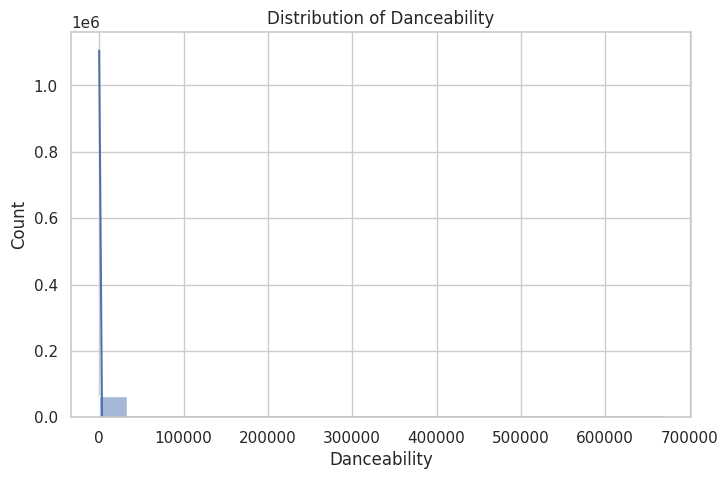

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Convert PySpark DataFrame to Pandas DataFrame for plotting
pandas_data = data.select('danceability').toPandas()

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(pandas_data['danceability'], bins=20, kde=True)
plt.title('Distribution of Danceability')
plt.xlabel('Danceability')
plt.show()


### Coreraltion matrix

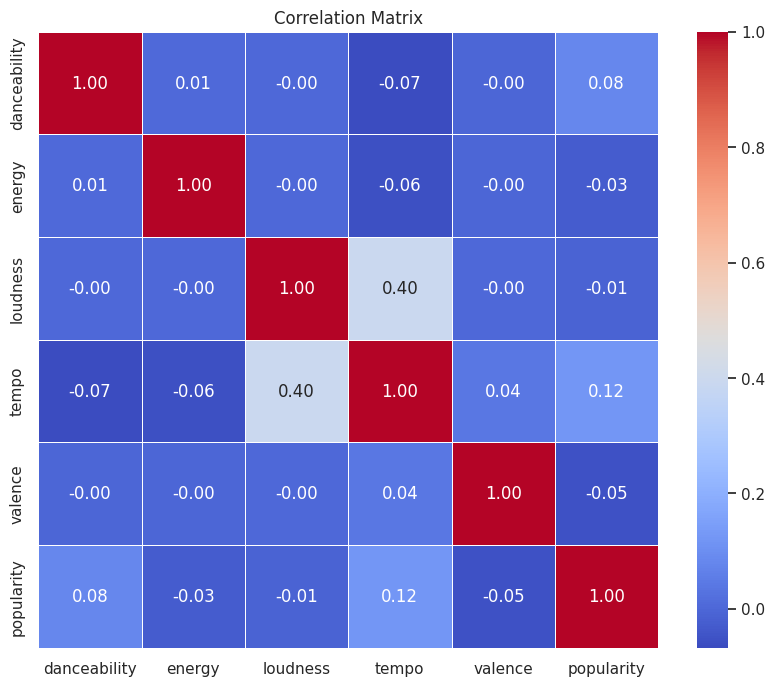

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Assuming 'data' is your PySpark DataFrame

# Select relevant numerical columns
numerical_columns = ['danceability', 'energy', 'loudness', 'tempo', 'valence', 'popularity']

# Convert selected columns to numerical types
for col_name in numerical_columns:
    data = data.withColumn(col_name, col(col_name).cast('double'))

# Create a feature vector
assembler = VectorAssembler(inputCols=numerical_columns, outputCol='features')
data_vectorized = assembler.transform(data)

# Compute correlation matrix
correlation_matrix = Correlation.corr(data_vectorized, 'features').head()
correlation_array = correlation_matrix[0].toArray()

# Create a Pandas DataFrame from the correlation array
import pandas as pd
correlation_df = pd.DataFrame(correlation_array, columns=numerical_columns, index=numerical_columns)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


### Time trends

#### Distribution of Tracks Over the Years:

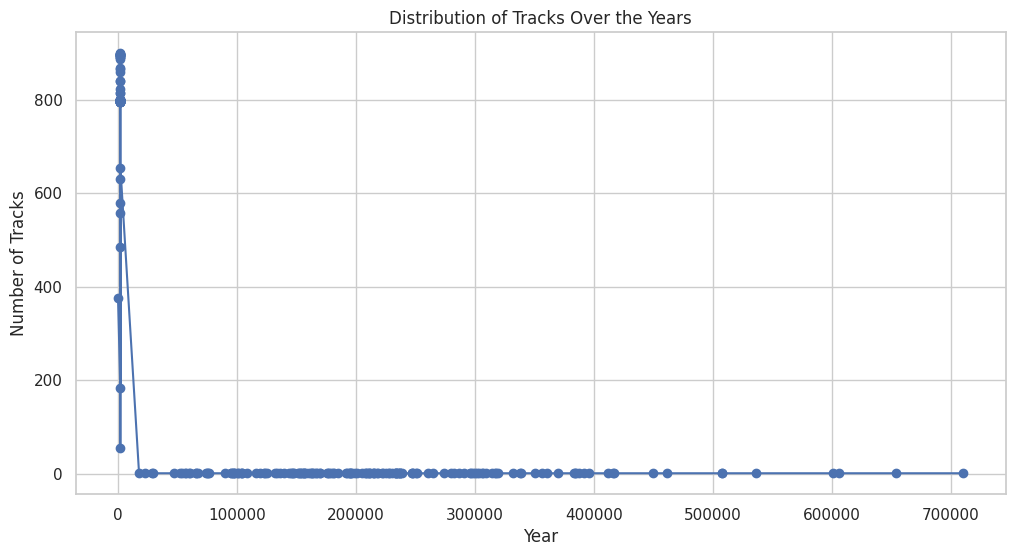

In [22]:
import matplotlib.pyplot as plt

# Convert 'year' column to integer
data = data.withColumn('year', col('year').cast('int'))

# Group by year and count the number of tracks
tracks_per_year = data.groupBy('year').count().orderBy('year')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tracks_per_year.toPandas()['year'], tracks_per_year.toPandas()['count'], marker='o')
plt.title('Distribution of Tracks Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Tracks')
plt.grid(True)
plt.show()


#### Average Musical Features Over Time

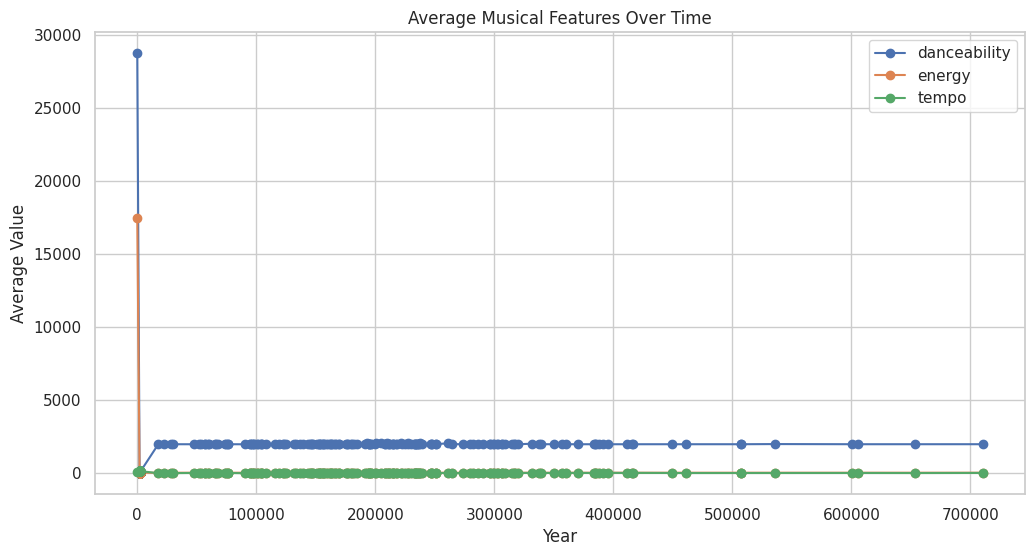

In [23]:
# Group by year and calculate the average of selected features
features = ['danceability', 'energy', 'tempo']
avg_features_per_year = data.groupBy('year').agg(*(mean(col(f)).alias(f) for f in features)).orderBy('year')

# Plotting
plt.figure(figsize=(12, 6))
for feature in features:
    plt.plot(avg_features_per_year.toPandas()['year'], avg_features_per_year.toPandas()[feature], label=feature, marker='o')

plt.title('Average Musical Features Over Time')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()


#### Popularity Trends Over Time

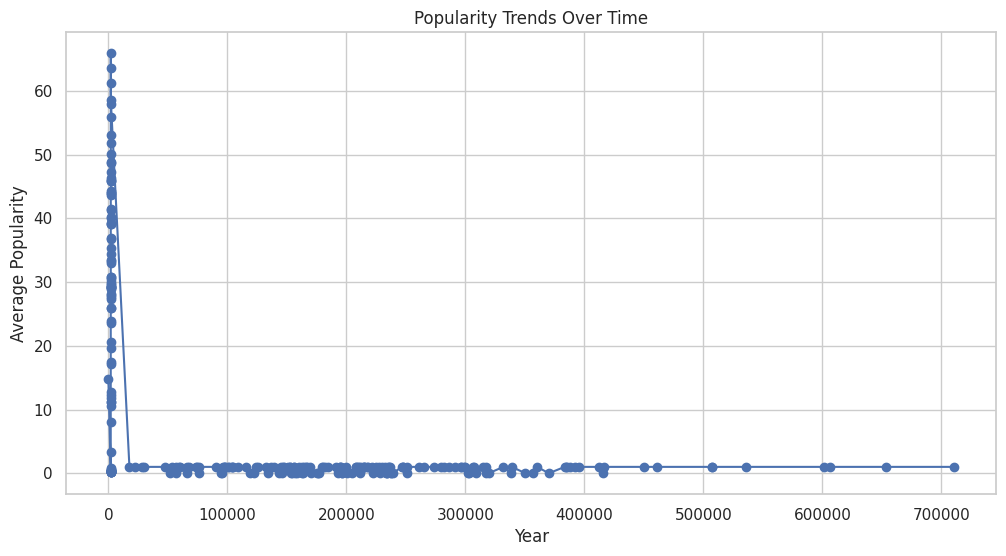

In [24]:
# Group by year and calculate the average popularity
avg_popularity_per_year = data.groupBy('year').agg(mean(col('popularity')).alias('avg_popularity')).orderBy('year')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(avg_popularity_per_year.toPandas()['year'], avg_popularity_per_year.toPandas()['avg_popularity'], marker='o')
plt.title('Popularity Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.grid(True)
plt.show()


### Correlation analysis

In [25]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Assuming 'data' is your PySpark DataFrame
numerical_columns = ['danceability', 'energy', 'loudness', 'tempo', 'valence', 'popularity']

# Convert selected columns to numerical types
for col_name in numerical_columns:
    data = data.withColumn(col_name, col(col_name).cast('double'))

# Create a feature vector
assembler = VectorAssembler(inputCols=numerical_columns, outputCol='features')
data_vectorized = assembler.transform(data)

# Compute correlation matrix
correlation_matrix = Correlation.corr(data_vectorized, 'features').head()
correlation_array = correlation_matrix[0].toArray()

# Print the correlation matrix
print("Correlation Matrix:")
for i in range(len(numerical_columns)):
    for j in range(len(numerical_columns)):
        print(f"{numerical_columns[i]} - {numerical_columns[j]}: {correlation_array[i][j]:.2f}")


Correlation Matrix:
danceability - danceability: 1.00
danceability - energy: 0.01
danceability - loudness: -0.00
danceability - tempo: -0.07
danceability - valence: -0.00
danceability - popularity: 0.08
energy - danceability: 0.01
energy - energy: 1.00
energy - loudness: -0.00
energy - tempo: -0.06
energy - valence: -0.00
energy - popularity: -0.03
loudness - danceability: -0.00
loudness - energy: -0.00
loudness - loudness: 1.00
loudness - tempo: 0.40
loudness - valence: -0.00
loudness - popularity: -0.01
tempo - danceability: -0.07
tempo - energy: -0.06
tempo - loudness: 0.40
tempo - tempo: 1.00
tempo - valence: 0.04
tempo - popularity: 0.12
valence - danceability: -0.00
valence - energy: -0.00
valence - loudness: -0.00
valence - tempo: 0.04
valence - valence: 1.00
valence - popularity: -0.05
popularity - danceability: 0.08
popularity - energy: -0.03
popularity - loudness: -0.01
popularity - tempo: 0.12
popularity - valence: -0.05
popularity - popularity: 1.00


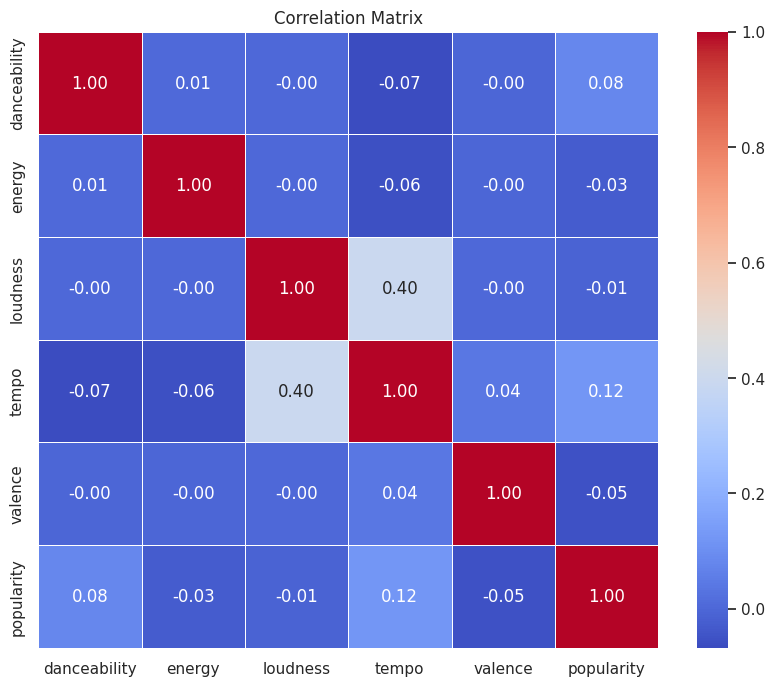

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert correlation matrix to a Pandas DataFrame
correlation_df = pd.DataFrame(correlation_array, columns=numerical_columns, index=numerical_columns)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


### Genre Analysis

In [30]:
# Assuming 'data' is your PySpark DataFrame

# Check the unique genres in the dataset
unique_genres = data.select('genre').distinct().rdd.flatMap(lambda x: x).collect()

# Count the number of tracks in each genre
tracks_per_genre = data.groupBy('genre').count().orderBy('count', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='genre', data=tracks_per_genre.toPandas(), palette='viridis')
plt.title('Distribution of Tracks Across Genres')
plt.xlabel('Number of Tracks')
plt.ylabel('Genre')
plt.show()


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `genre` cannot be resolved. Did you mean one of the following? [`year`, `energy`, `id`, `key`, `mode`].;
'Project ['genre]
+- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1853, acousticness#1565, danceability#2005, energy#2025, instrumentalness#1568, liveness#1569, loudness#2045, speechiness#1571, tempo#2065, valence#2085, mode#32, key#33, cast(popularity#1801 as double) AS popularity#2105, explicit#1575]
   +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1853, acousticness#1565, danceability#2005, energy#2025, instrumentalness#1568, liveness#1569, loudness#2045, speechiness#1571, tempo#2065, cast(valence#1781 as double) AS valence#2085, mode#32, key#33, popularity#1801, explicit#1575]
      +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1853, acousticness#1565, danceability#2005, energy#2025, instrumentalness#1568, liveness#1569, loudness#2045, speechiness#1571, cast(tempo#1761 as double) AS tempo#2065, valence#1781, mode#32, key#33, popularity#1801, explicit#1575]
         +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1853, acousticness#1565, danceability#2005, energy#2025, instrumentalness#1568, liveness#1569, cast(loudness#1741 as double) AS loudness#2045, speechiness#1571, tempo#1761, valence#1781, mode#32, key#33, popularity#1801, explicit#1575]
            +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1853, acousticness#1565, danceability#2005, cast(energy#1721 as double) AS energy#2025, instrumentalness#1568, liveness#1569, loudness#1741, speechiness#1571, tempo#1761, valence#1781, mode#32, key#33, popularity#1801, explicit#1575]
               +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1853, acousticness#1565, cast(danceability#1701 as double) AS danceability#2005, energy#1721, instrumentalness#1568, liveness#1569, loudness#1741, speechiness#1571, tempo#1761, valence#1781, mode#32, key#33, popularity#1801, explicit#1575]
                  +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, cast(year#1564 as int) AS year#1853, acousticness#1565, danceability#1701, energy#1721, instrumentalness#1568, liveness#1569, loudness#1741, speechiness#1571, tempo#1761, valence#1781, mode#32, key#33, popularity#1801, explicit#1575]
                     +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1564, acousticness#1565, danceability#1701, energy#1721, instrumentalness#1568, liveness#1569, loudness#1741, speechiness#1571, tempo#1761, valence#1781, mode#32, key#33, cast(popularity#1574 as double) AS popularity#1801, explicit#1575]
                        +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1564, acousticness#1565, danceability#1701, energy#1721, instrumentalness#1568, liveness#1569, loudness#1741, speechiness#1571, tempo#1761, cast(valence#1573 as double) AS valence#1781, mode#32, key#33, popularity#1574, explicit#1575]
                           +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1564, acousticness#1565, danceability#1701, energy#1721, instrumentalness#1568, liveness#1569, loudness#1741, speechiness#1571, cast(tempo#1572 as double) AS tempo#1761, valence#1573, mode#32, key#33, popularity#1574, explicit#1575]
                              +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1564, acousticness#1565, danceability#1701, energy#1721, instrumentalness#1568, liveness#1569, cast(loudness#1570 as double) AS loudness#1741, speechiness#1571, tempo#1572, valence#1573, mode#32, key#33, popularity#1574, explicit#1575]
                                 +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1564, acousticness#1565, danceability#1701, cast(energy#1567 as double) AS energy#1721, instrumentalness#1568, liveness#1569, loudness#1570, speechiness#1571, tempo#1572, valence#1573, mode#32, key#33, popularity#1574, explicit#1575]
                                    +- Project [id#17, name#18, artists#19, duration_ms#1563, release_date#21, year#1564, acousticness#1565, cast(danceability#1566 as double) AS danceability#1701, energy#1567, instrumentalness#1568, liveness#1569, loudness#1570, speechiness#1571, tempo#1572, valence#1573, mode#32, key#33, popularity#1574, explicit#1575]
                                       +- Project [id#17, name#18, artists#19, coalesce(nanvl(duration_ms#55, cast(null as double)), cast(0.0 as double)) AS duration_ms#1563, release_date#21, coalesce(nanvl(year#76, cast(null as double)), cast(0.0 as double)) AS year#1564, coalesce(nanvl(acousticness#96, cast(null as double)), cast(0.0 as double)) AS acousticness#1565, coalesce(nanvl(danceability#116, cast(null as double)), cast(0.0 as double)) AS danceability#1566, coalesce(nanvl(energy#136, cast(null as double)), cast(0.0 as double)) AS energy#1567, coalesce(nanvl(instrumentalness#156, cast(null as double)), cast(0.0 as double)) AS instrumentalness#1568, coalesce(nanvl(liveness#176, cast(null as double)), cast(0.0 as double)) AS liveness#1569, coalesce(nanvl(loudness#196, cast(null as double)), cast(0.0 as double)) AS loudness#1570, coalesce(nanvl(speechiness#216, cast(null as double)), cast(0.0 as double)) AS speechiness#1571, coalesce(nanvl(tempo#236, cast(null as double)), cast(0.0 as double)) AS tempo#1572, coalesce(nanvl(valence#256, cast(null as double)), cast(0.0 as double)) AS valence#1573, mode#32, key#33, coalesce(nanvl(popularity#276, cast(null as double)), cast(0.0 as double)) AS popularity#1574, coalesce(nanvl(explicit#296, cast(null as double)), cast(0.0 as double)) AS explicit#1575]
                                          +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, year#76, acousticness#96, danceability#116, energy#136, instrumentalness#156, liveness#176, loudness#196, speechiness#216, tempo#236, valence#256, mode#32, key#33, popularity#276, cast(explicit#35 as double) AS explicit#296]
                                             +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, year#76, acousticness#96, danceability#116, energy#136, instrumentalness#156, liveness#176, loudness#196, speechiness#216, tempo#236, valence#256, mode#32, key#33, cast(popularity#34 as double) AS popularity#276, explicit#35]
                                                +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, year#76, acousticness#96, danceability#116, energy#136, instrumentalness#156, liveness#176, loudness#196, speechiness#216, tempo#236, cast(valence#31 as double) AS valence#256, mode#32, key#33, popularity#34, explicit#35]
                                                   +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, year#76, acousticness#96, danceability#116, energy#136, instrumentalness#156, liveness#176, loudness#196, speechiness#216, cast(tempo#30 as double) AS tempo#236, valence#31, mode#32, key#33, popularity#34, explicit#35]
                                                      +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, year#76, acousticness#96, danceability#116, energy#136, instrumentalness#156, liveness#176, loudness#196, cast(speechiness#29 as double) AS speechiness#216, tempo#30, valence#31, mode#32, key#33, popularity#34, explicit#35]
                                                         +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, year#76, acousticness#96, danceability#116, energy#136, instrumentalness#156, liveness#176, cast(loudness#28 as double) AS loudness#196, speechiness#29, tempo#30, valence#31, mode#32, key#33, popularity#34, explicit#35]
                                                            +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, year#76, acousticness#96, danceability#116, energy#136, instrumentalness#156, cast(liveness#27 as double) AS liveness#176, loudness#28, speechiness#29, tempo#30, valence#31, mode#32, key#33, popularity#34, explicit#35]
                                                               +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, year#76, acousticness#96, danceability#116, energy#136, cast(instrumentalness#26 as double) AS instrumentalness#156, liveness#27, loudness#28, speechiness#29, tempo#30, valence#31, mode#32, key#33, popularity#34, explicit#35]
                                                                  +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, year#76, acousticness#96, danceability#116, cast(energy#25 as double) AS energy#136, instrumentalness#26, liveness#27, loudness#28, speechiness#29, tempo#30, valence#31, mode#32, key#33, popularity#34, explicit#35]
                                                                     +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, year#76, acousticness#96, cast(danceability#24 as double) AS danceability#116, energy#25, instrumentalness#26, liveness#27, loudness#28, speechiness#29, tempo#30, valence#31, mode#32, key#33, popularity#34, explicit#35]
                                                                        +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, year#76, cast(acousticness#23 as double) AS acousticness#96, danceability#24, energy#25, instrumentalness#26, liveness#27, loudness#28, speechiness#29, tempo#30, valence#31, mode#32, key#33, popularity#34, explicit#35]
                                                                           +- Project [id#17, name#18, artists#19, duration_ms#55, release_date#21, cast(year#22 as double) AS year#76, acousticness#23, danceability#24, energy#25, instrumentalness#26, liveness#27, loudness#28, speechiness#29, tempo#30, valence#31, mode#32, key#33, popularity#34, explicit#35]
                                                                              +- Project [id#17, name#18, artists#19, cast(duration_ms#20 as double) AS duration_ms#55, release_date#21, year#22, acousticness#23, danceability#24, energy#25, instrumentalness#26, liveness#27, loudness#28, speechiness#29, tempo#30, valence#31, mode#32, key#33, popularity#34, explicit#35]
                                                                                 +- Relation [id#17,name#18,artists#19,duration_ms#20,release_date#21,year#22,acousticness#23,danceability#24,energy#25,instrumentalness#26,liveness#27,loudness#28,speechiness#29,tempo#30,valence#31,mode#32,key#33,popularity#34,explicit#35] csv


In [31]:
data.show()

+--------------------+--------------------+--------------------+-----------+------------+----+------------+------------+-------+----------------+--------+--------+-----------+-------+-------+----+---+----------+--------+
|                  id|                name|             artists|duration_ms|release_date|year|acousticness|danceability| energy|instrumentalness|liveness|loudness|speechiness|  tempo|valence|mode|key|popularity|explicit|
+--------------------+--------------------+--------------------+-----------+------------+----+------------+------------+-------+----------------+--------+--------+-----------+-------+-------+----+---+----------+--------+
|6KbQ3uYMLKb5jDxLF...|Singende Bataillo...| ['Carl Woitschach']|   158648.0|        1928|1928|       0.995|       0.708|  0.195|           0.563|   0.151| -12.428|     0.0506|118.469|  0.779|   1| 10|       0.0|     0.0|
|6KuQTIu1KoTTkLXKr...|Fantasiestücke, O...|['Robert Schumann...|   282133.0|        1928|1928|       0.994|       0.

### Top Artists/Tracks:

<ipython-input-32-29d18ecbfa4a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_popularity', y='artists', data=avg_popularity_per_artist.limit(10).toPandas(), palette='magma')


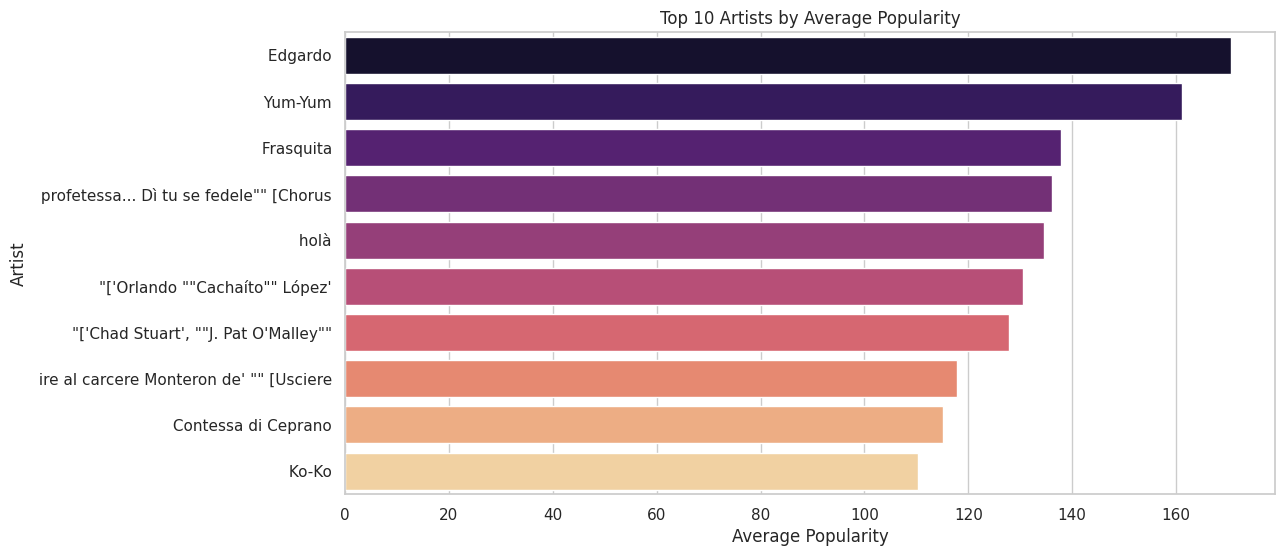

In [32]:
# Assuming 'data' is your PySpark DataFrame

# Group by artist and calculate the average popularity
avg_popularity_per_artist = data.groupBy('artists').agg(mean(col('popularity')).alias('avg_popularity')).orderBy('avg_popularity', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='avg_popularity', y='artists', data=avg_popularity_per_artist.limit(10).toPandas(), palette='magma')
plt.title('Top 10 Artists by Average Popularity')
plt.xlabel('Average Popularity')
plt.ylabel('Artist')
plt.show()


<ipython-input-33-e188c3edc48a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='artists', data=track_count_per_artist.limit(10).toPandas(), palette='viridis')


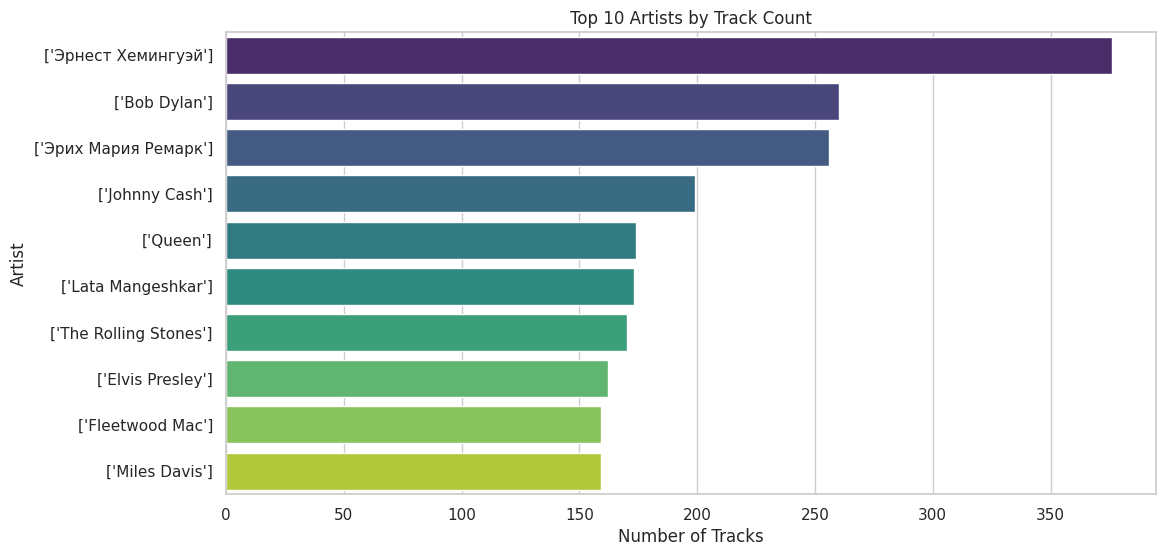

In [33]:
# Assuming 'data' is your PySpark DataFrame

# Count the number of tracks per artist
track_count_per_artist = data.groupBy('artists').count().orderBy('count', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='artists', data=track_count_per_artist.limit(10).toPandas(), palette='viridis')
plt.title('Top 10 Artists by Track Count')
plt.xlabel('Number of Tracks')
plt.ylabel('Artist')
plt.show()


<ipython-input-34-2e9b94883561>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='popularity', y='name', data=top_tracks_by_popularity.toPandas(), palette='plasma')


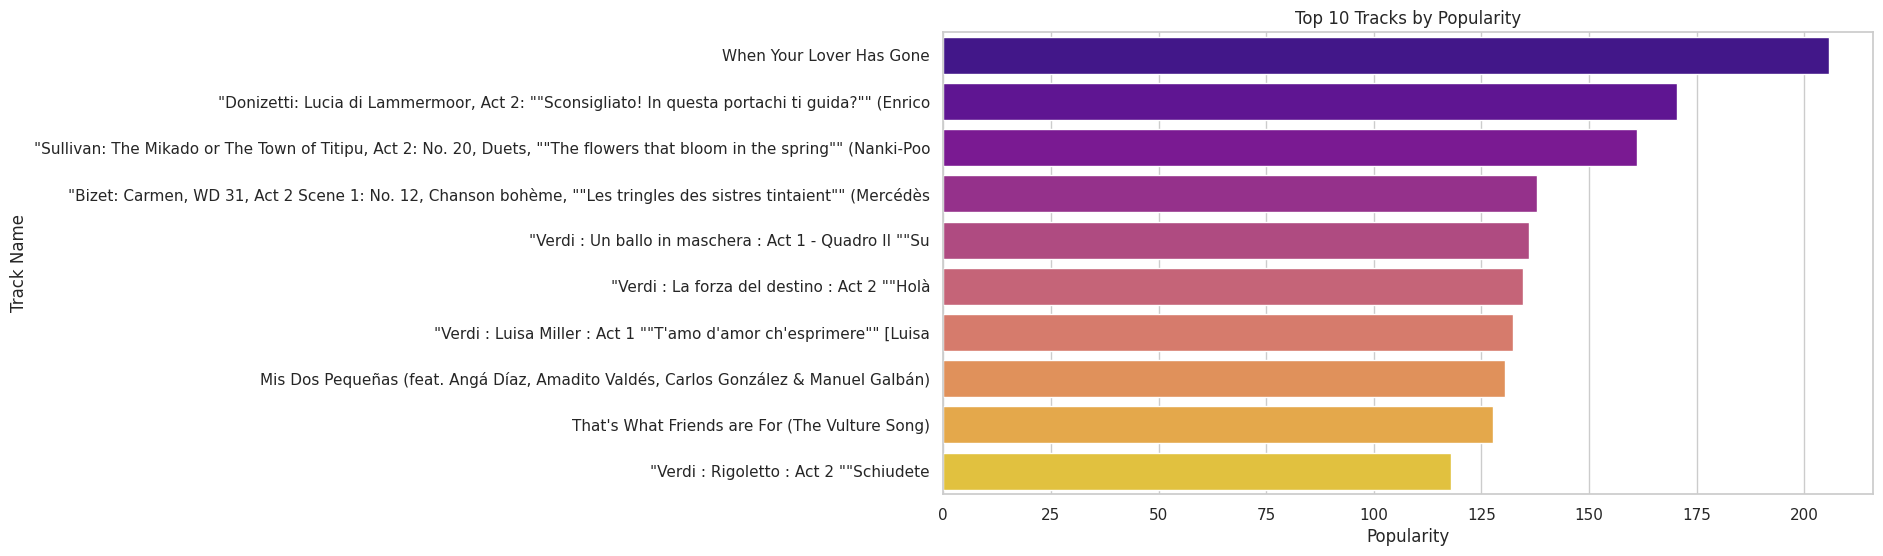

In [34]:
# Assuming 'data' is your PySpark DataFrame

# Select top tracks by popularity
top_tracks_by_popularity = data.orderBy('popularity', ascending=False).limit(10)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='popularity', y='name', data=top_tracks_by_popularity.toPandas(), palette='plasma')
plt.title('Top 10 Tracks by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Track Name')
plt.show()


## **Cluster Analysis**

In [35]:
from pyspark.ml.feature import VectorAssembler

# Assuming 'data' is your PySpark DataFrame

# Select relevant features for clustering
features = ['danceability', 'energy', 'tempo']

# Create a feature vector
assembler = VectorAssembler(inputCols=features, outputCol='features')
data_vectorized = assembler.transform(data)


In [36]:
from pyspark.ml.feature import StandardScaler

# Standardize the feature vector
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(data_vectorized)
data_scaled = scaler_model.transform(data_vectorized)


In [37]:
from pyspark.ml.clustering import KMeans

# Assuming 'data_scaled' is your PySpark DataFrame with standardized features

# Set the number of clusters (you can adjust this based on your analysis)
num_clusters = 3

# Fit the K-Means model
kmeans = KMeans(featuresCol='scaled_features', k=num_clusters, seed=42)
kmeans_model = kmeans.fit(data_scaled)

# Add cluster labels to the original DataFrame
data_clustered = kmeans_model.transform(data_scaled)


In [38]:
# Assuming 'data_clustered' is your PySpark DataFrame with cluster labels

# Group by cluster and calculate the average of selected features
avg_features_per_cluster = data_clustered.groupBy('prediction').agg(*(mean(col(f)).alias(f) for f in features)).orderBy('prediction')

# Print or visualize the results
avg_features_per_cluster.show()


+----------+------------------+------------------+------------------+
|prediction|      danceability|            energy|             tempo|
+----------+------------------+------------------+------------------+
|         0|309.47311847583273|25.525812856422586| 92.33911158711982|
|         1|               0.0|257032.81818181818|0.3382590909090909|
|         2|0.5273265227817749|0.5554932605344312| 145.0529051730036|
+----------+------------------+------------------+------------------+



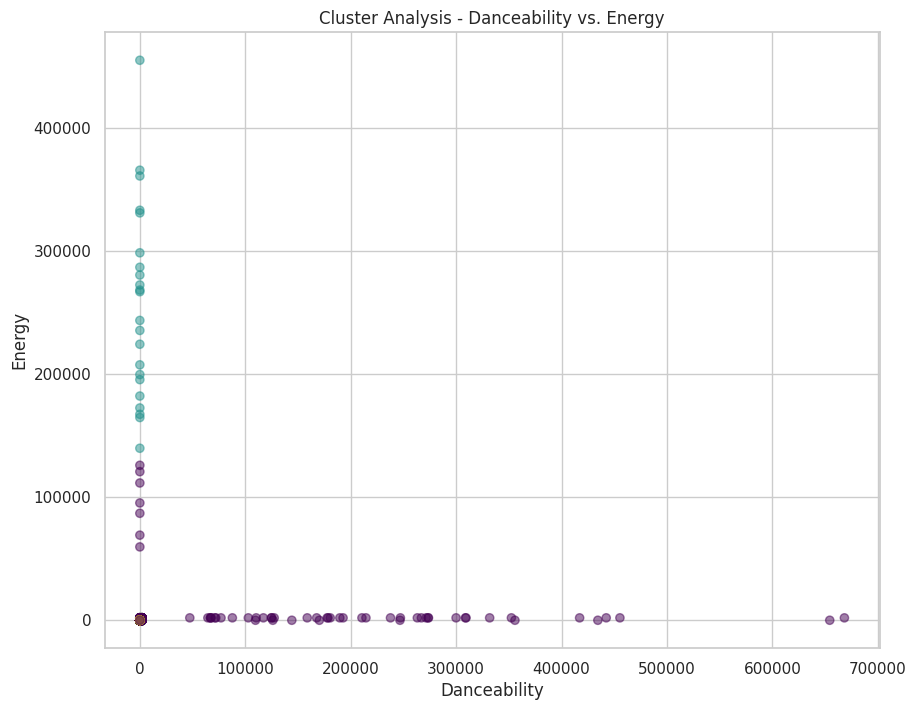

In [39]:
import matplotlib.pyplot as plt

# Assuming 'data_clustered' is your PySpark DataFrame with cluster labels

# Convert PySpark DataFrame to Pandas DataFrame for plotting
pandas_data = data_clustered.select('danceability', 'energy', 'tempo', 'prediction').toPandas()

# Plot scatter plot for 2D or 3D visualization
plt.figure(figsize=(10, 8))
plt.scatter(pandas_data['danceability'], pandas_data['energy'], c=pandas_data['prediction'], cmap='viridis', alpha=0.5)
plt.title('Cluster Analysis - Danceability vs. Energy')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.show()
